In [2]:
import os
import fnmatch
import fitz #pip install PyMuPDF
import re
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:

#read all PDF files
def find_all_files(path):
    all_files = []

    for root, dirs, files in os.walk(path):
        for file in fnmatch.filter(files,'*.pdf'):
#
            full_path=os.path.abspath(file)
            all_files.append(os.path.join(root, file))
    return all_files

In [4]:
#Specify the path of the folder to look the PDFs of the bills
initial_folder='.'
pdf_files=find_all_files(initial_folder)
# List of every page's text.
# # The index will correspond to the pdf number.
pdf_text = []
for file in pdf_files:
   doc = fitz.open(file)
   text = ""
   for page in doc:
      text+=page.get_text()
   pdf_text.append(text)

In [5]:
#Function to read the amount to pay. It always has the symbol * before the amount (in Euros), e.g., *195,00 
def find_amount(text,amount):
    match=re.search(r'\*\d{1,},\d{1,}',text)
    #add exception when there is a refund and no amount is written
    try:
        #print(match.group(0))
        value=match.group(0)[1:]
        value=value[:-1]
        value=value.replace(',', '.')
        amount.append(float(value))
    except:
        print('Add zero if the bill is negative')
        amount.append(0)
    else:
         pass
    return amount

In [6]:
#Function to read the consumption of kWh 
def find_consumption(text,amount):
    match=re.search(r"\d{1,} kWh|\d.\d{1,} kWh",text)
    #print(match)
    #add exception when there is a refund and no amount is written
    # ATTENTION::: FIX The 
    try:
        #print(match.group(0))
        value=match.group(0).split()
        amount.append(float(value[0]))
    except:
        print('Add zero if there is no consumption')
        amount.append(0)

    return amount

In [7]:
#Function to read the date of consumption 
def find_date_old(text,begin,end,bill,dts):
    match=re.findall(r"\d{2}/\d{2}/\d{4}",text)
    #print(match)
    #25/06/2022
    #add exception when there is a refund and no amount is written
    # try:
    #     print(match.group(0))
    #     #value=match.group(0).split()
    #     #amount.append(value[0])
    # except:
    #     print('No data for period of consumption available')
    #     amount.append(0)
    #amount.append(match[1:3])
    dts=[]
    for dt in match:
        date_time_obj = datetime.strptime(dt,'%d/%m/%Y')
        #print(date_time_obj)
        dts.append(date_time_obj.date())
        #print(dts)
    #check date because the format of date changes after some bills
    #Before the change in the bills (last bill of 2020)
    if (dts[1]<dts[2] and dts[2]<dts[3]):
        begin.append(dts[1])
        end.append(dts[2])
        bill.append(dts[0])
    else:
        begin.append(dts[2])
        end.append(dts[3])
        bill.append(dts[4])       
    #Add date of bill
    #match_bill==re.search(r"Έκδοσης\n\d{2}/\d{2}/\d{4}",text)
    #chk=re.match(r"Έκδοσης\n\d{2}/\d{2}/\d{4}",text==True)
    #if chk:
    #    date_time_obj = datetime.strptime(chk,'%d/%m/%Y')
    #    bill.append(dts[0])
    #else:
    #    bill.append(dts[0])

    return begin,end,bill,dts

In [34]:
#Function to read the dates of the bill 
def find_date(text,begin,end,bill,amount):
    #First find all dates in the text
    match=re.findall(r"\d{2}/\d{2}/\d{4}",text)
    dts=[]
    for i in match:
        date_time_obj = datetime.strptime(i,'%d/%m/%Y')
        #print(date_time_obj)
        dts.append(date_time_obj.date())
        #print(dts)

    #Older bills dont have these patterns while the new ones do
    regex_date_publish = re.compile(r'(Έκδοσης)\n(\d{2}/\d{2}/\d{4})')
    regex_date_publish_2 = re.compile(r'(\d{10})\s*-\s*(\d{2}/\d{2}/\d{4})')
    
    match = regex_date_publish.search(text)
    match_2 = regex_date_publish_2.search(text)
    #print(match,match_2)
    dt=''
    dt_d=datetime.strptime('01/01/2000','%d/%m/%Y')
    if match: #New bill
        word = match.group(1)
        type(match.group(2))
        dt=match.group(2)
        dt_d = datetime.strptime(dt,'%d/%m/%Y')
        bill.append(dt_d.date())
        #print(word) # output: Έκδοσης
        #print(match.group(2)) # output: 24/03/2023
    elif match_2: #Older bills
        dt=match_2.group(2)
        dt_d = datetime.strptime(dt,'%d/%m/%Y')
        bill.append(dt_d.date())       
        #print('Middle bill')

    #Consumption period
    regex_date_period = re.compile(r'(Κατανάλωσης)\n(\d{2}/\d{2}/\d{4})\s+-\s+(\d{2}/\d{2}/\d{4})')
    regex_date_period_2 = re.compile(r'\n(\d{2}/\d{2}/\d{4})\s+-\s+(\d{2}/\d{2}/\d{4})\n')
    match = regex_date_period.search(text)
    match_2 = regex_date_period_2.search(text)
    #print(match)
    if match: #New bill
        title = match.group(1)
        start_date = match.group(2)
        end_date= match.group(3)
        
        start_date=datetime.strptime(start_date,'%d/%m/%Y')
        end_date=datetime.strptime(end_date,'%d/%m/%Y')
        
        begin.append( start_date.date())
        end.append(end_date.date())
        
        print(f"Title: {title}\nStart Date: {start_date}\nEnd Date: {end_date}")
    elif match_2: #Second format
        start_date = match_2.group(1)
        end_date= match_2.group(2)
        print('Middle bill')
        start_date=datetime.strptime(start_date,'%d/%m/%Y')
        end_date=datetime.strptime(end_date,'%d/%m/%Y')
        
        begin.append( start_date.date())
        end.append(end_date.date())     

    else: #Find start and end date based on the date of the bill
        check_date=datetime.strptime('01/12/2020','%d/%m/%Y')
        #The format of the bill changes at the end of the 2020.
        print(dt_d.date())
        if dt_d<check_date:
            begin.append(dts[1])
            end.append(dts[2])
        else:
            begin.append(dts[2])
            #If there is a refund, then the number of the period end moves up since there is no due date.
            if amount[-1]==0:
                print('mpika')
                end.append(dts[4])
            else:
                end.append(dts[5])           

    return begin,end,bill

In [9]:
pdf_text[28]

"ΔΗΜΟΣΙΑ ΕΠΙΧΕΙΡΗΣΗ ΗΛΕΚΤΡΙΣΜΟΥ Α.Ε.\nΧαλκοκονδύλη 30,104 32 Αθήνα, e-mail: info@dei.com.gr\nΑ.Φ.Μ. 090000045, Δ.Ο.Υ. ΦΑΕ ΑΘΗΝΩΝ\nwww.dei.gr\nΑριθμός Παροχής\nΕπόμενη Καταμέτρηση:\nΔιεύθυνση Ακινήτου\nΚαταμέτρηση:\nΠληροφορίες:\n Βλάβες:\nΕξυπηρέτηση Πελατών ΔΕΗ\nΕξυπηρέτηση ΔΕΔΔΗΕ\nΕίδος Λογαριασμού\nΑρ. Παραστατικού\nΠερίοδος Κατανάλωσης\nΗμέρες\nΚατανάλωση Ηλεκτρικής Ενέργειας\nΗμερομηνία Έκδοσης\nΑ/Α Λογαριασμού\nΑΦΜ/ΑΔΤ\nΕγγύηση\nΛογαριασμός Συμβολαίου\nΤιμολόγιο\nΣτοιχεία Πελάτη\nΚωδικός Εταίρου\nΑΝΤΙΓΡΑΦΟ\nΟ λογαριασμός  σας  συνοπτικά\nΑΔΜΗΕ- ΔΕΔΔΗΕ\nΥΚΩ\nΕΤΜΕΑΡ\nΛοιπές Χρεώσεις\nΈναντι Κατανάλωσης\nΔιάφορα\nΠροηγούμενο Ανεξόφλητο Ποσό\nΣΥΝΟΛΙΚΟ  ΠΟΣΟ  ΠΛΗΡΩΜΗΣ\n(Αγνοήστε το εάν έχει πληρωθεί)\nΑξία σε €\nΔΕΗ\nΝησιά / Κοινωνικό Τιμολόγιο / Πολύτεκνοι κ.λπ.\nΑνανεώσιμες Πηγές Ενέργειας\nΕΦΚ / Ειδικό Τέλος 5        κ.λπ.\nΧρεώσεις  ΔΗΜΟΥ\nΦΠΑ\nΕΡΤ\nΛήξη Προθεσμίας Πληρωμής\nΚωδικός Ηλεκτρονικής Πληρωμής\nΟ Κωδικός Ηλεκτρονικής Πληρωμής άλλαξε.\nΓια τις πληρωμές σας χρησιμοποιήστε

In [10]:
import re

text = "Σε συνέχεια του υπ' αριθμού A/A Λογαριασμού 1259012181 - 26/05/2021 με αριθμό παροχής"
pattern = r'(\d+)\s*-\s*(\d{2}/\d{2}/\d{4})'

match = re.search(pattern, pdf_text[32])
if match:
    date = match.group(2)
    print(date)
else:
    print("No match found")


18/12/2019


In [11]:
import re

# Define the text to search
text = "ότι Η Έκδοσης του βιβλίου ολοκληρώθηκε επιτέλους!"
#re.findall(r"\d{2}/\d{2}/\d{4}",text)
# Define the regular expression to search for Greek letters
#regex = "[Α-Ωα-ωάέ]+"
#Έκδοσης\n24/03/2023
regex_date_publish = re.compile(r'Έκδοσης\n\d{2}/\d{2}/\d{4}')
regex_date_period = re.compile(r'Κατανάλωσης\n\d{2}/\d{2}/\d{4}')
regex_date_period = re.compile(r'(Κατανάλωσης)\n(\d{2}/\d{2}/\d{4})\s+-\s+(\d{2}/\d{2}/\d{4})')
# Use the findall method to search for all occurrences of Greek letters in the text
matches = re.search(regex_date_period, pdf_text[-1])

# Print the matches
print(matches)

<re.Match object; span=(1255, 1298), match='Κατανάλωσης\n23/02/2023     -     23/03/2023'>


In [12]:
import re

text = 'Lorem ipsum Έκδοσης\n24/03/2023 dolor sit amet.'

pattern = re.compile(r'(Έκδοσης)\n(\d{2}/\d{2}/\d{4})')

match = pattern.search(text)
print(match)
if match:
    word = match.group(1)
    date = match.group(2)
    print(word) # output: Έκδοσης
    print(date) # output: 24/03/2023

<re.Match object; span=(12, 30), match='Έκδοσης\n24/03/2023'>
Έκδοσης
24/03/2023


In [13]:
# # date in yyyy/mm/dd format
# d1 = dt.datetime(2018, 5, 3)
# d2 = dt.datetime(2018, 6, 1)
  
# # Comparing the dates will return
# # either True or False
# print("d1 is greater than d2 : ", d1 > d2)
# print("d1 is less than d2 : ", d1 < d2)
# print("d1 is not equal to d2 : ", d1 != d2)
from datetime import datetime
date_time_obj = datetime.strptime('30/06/2016','%d/%m/%Y')
date_time_obj_2 = datetime.strptime('20/06/2016','%d/%m/%Y')
print(date_time_obj.date()-date_time_obj_2.date())

10 days, 0:00:00


In [35]:
#Extract the info that we want
#Katanalosi, euro and date
monthly_pay=[]
consumption=[]
begin_consumption=[]
end_consumption=[]
date_bill=[]
dates=[]

#Iterate over the extracted PDF text.
for f in pdf_text:
    #First, find what do we pay each month.
    find_amount(f,monthly_pay)
    #Next, find the date of consumption.
    find_date(f,begin_consumption,end_consumption,date_bill,monthly_pay)
    #Finally, find the consumption of kWh.
    find_consumption(f,consumption)


Add zero if the bill is negative
2000-01-01


IndexError: list index out of range

In [ ]:
#fix delimiter in new bills

number = consumption[-1]  # Float value with a point as a thousand separator
tst=str(number).split(".")
print(tst[1]>tst[0])
number = str(number).replace(".", "")  # Remove the point
number = float(number)  # Convert the result back to float
print(number)

False
2800.0


In [ ]:
#fix point delimiter considered as thousand in new bills
for month in consumption:
    try:
        #Check if consumption has a point delimiter that denotes thousand instead of decimal
        check=str(month).split(".")
        if check[1]>check[0]: #It is going to have at least 3 values after the point that denotes thousands
            number = str(month).replace(".", "")  # Remove the point
            consumption[consumption.index(month)] = float(number)  # Convert the result back to float
    except:
        pass

In [ ]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df = pd.DataFrame(list(zip(date_bill,begin_consumption, end_consumption,consumption,monthly_pay,pdf_files)),
               columns =['Date_bill','Start', 'End','Consumption','Bill','Pdf_file'])
# forming dataframe
data = pd.DataFrame(df) 

#
# storing into the excel file
data.to_excel("output.xlsx")

In [ ]:
#df.groupby(pd.to_datetime(df['Start of consumption']).dt.year).sum()

df['quarter'] = pd.to_datetime(df['Date_bill']).dt.quarter
df['year'] = pd.to_datetime(df['Date_bill']).dt.year
#df.quarter=df.quarter.astype(str)
#df.groupby(df['quarter']).sum()
#type(df['quarter'])

In [ ]:
#test=df.groupby(df['quarter']).sum()
#test.dtypes

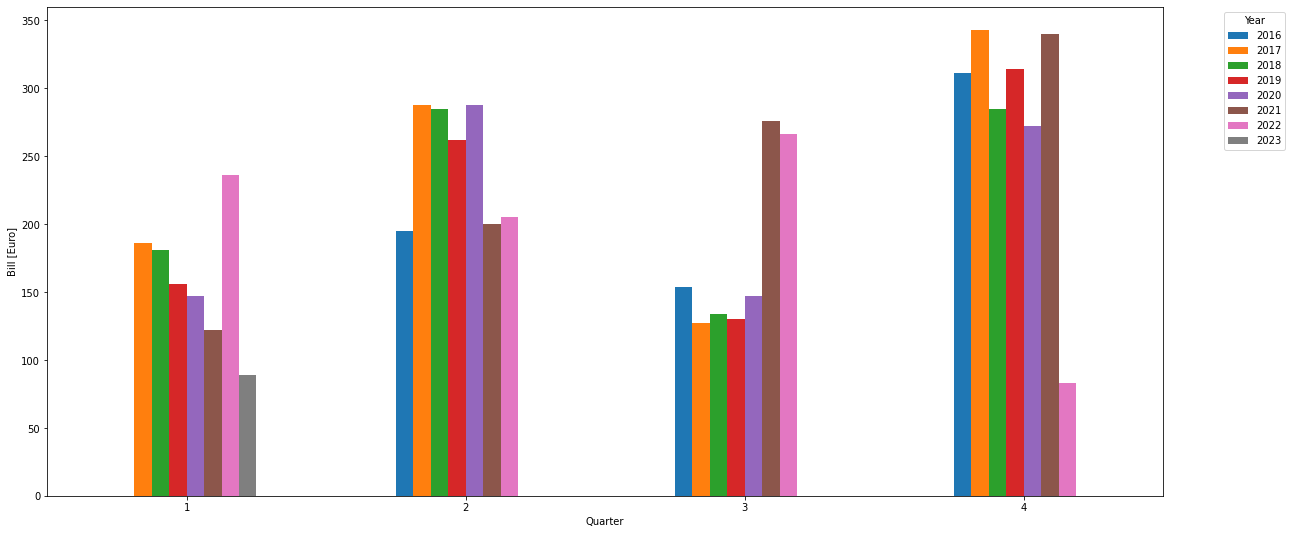

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# group data by year and quarter
grouped = df.groupby(['year','quarter']).sum()

# reshape data into a pivot table
pivot = grouped.pivot_table(index='quarter', columns='year', values=['Bill','Consumption'], aggfunc=np.sum)

# create the bar chart
ax = pivot.plot(kind='bar', figsize=(20,9))

# set the x-axis label and tick labels
ax.set_xlabel('Quarter')
ax.set_xticklabels(pivot.index, rotation=0)

# set the y-axis label
ax.set_ylabel('Bill [Euro]')

# set the legend
ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
Q1 = [12, 30, 1, 8, 22]
Q2 = [28, 6, 16, 5, 10]
Q3 = [29, 3, 24, 25, 17]
Q4 = [29, 3, 24, 25, 17]

# Set position of bar on X axis
br1 = np.arange(len(Q1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, Q1, color ='r', width = barWidth,
		edgecolor ='grey', label ='Q1')
plt.bar(br2, Q2, color ='g', width = barWidth,
		edgecolor ='grey', label ='Q2')
plt.bar(br3, Q3, color ='b', width = barWidth,
		edgecolor ='grey', label ='Q3')
plt.bar(br4, Q4, color ='b', width = barWidth,
		edgecolor ='grey', label ='Q4')

# Adding Xticks
plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
plt.ylabel('Students passed', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Q1))],
		['2015', '2016', '2017', '2018', '2019'])

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

quarters = ['Q1', 'Q2', 'Q3', 'Q4']
year1 = [100, 150, 200, 250]
year2 = [125, 175, 225, 275]
year3 = [110, 170, 210, 280]

x = np.arange(len(quarters))  # the x locations for the quarters
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, year1, width, label='Year 1')
rects2 = ax.bar(x, year2, width, label='Year 2')
rects3 = ax.bar(x + width, year3, width, label='Year 3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energy Bill')
ax.set_title('Energy Bills by Quarter and Year')
ax.set_xticks(x)
ax.set_xticklabels(quarters)
ax.legend()

fig.tight_layout()

plt.show()


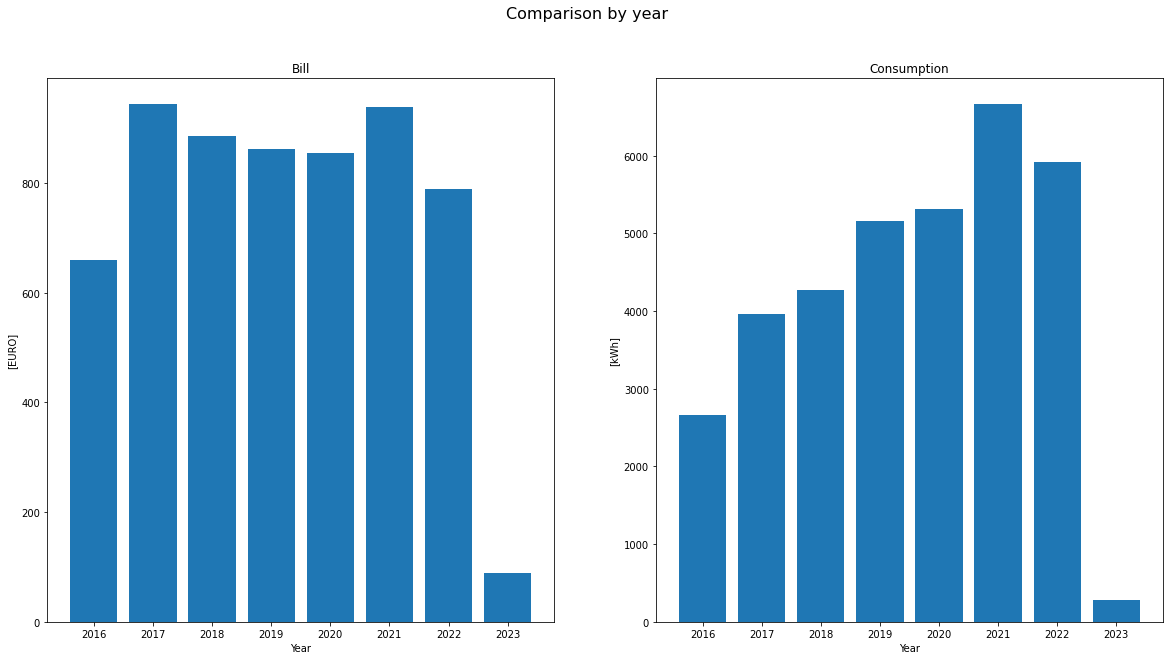

In [ ]:
#Results for each a year
df_year=df.groupby(pd.to_datetime(df['Date_bill']).dt.year).sum()

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first bar figure in the left subplot
axs[0].bar(df_year.index, df_year['Bill'])
axs[0].set_title('Bill')
axs[0].set_ylabel('[EURO]')
axs[0].set_xlabel('Year')
# Plot the second bar figure in the right subplot
axs[1].bar(df_year.index, df_year['Consumption'])
axs[1].set_title('Consumption')
axs[1].set_ylabel('[kWh]')
axs[1].set_xlabel('Year')
# Add a title to the overall figure
fig.suptitle('Comparison by year', fontsize=16)
# Display the plot
plt.show()


In [ ]:
#pdf_files
#pdf_text[-1]

#PyPDF2 doenst work!
# for file in pdf_files[0:1]:
#     f = open(file,'rb')

#     # List of every page's text.
#     # The index will correspond to the page number.
#     pdf_text = []

#     pdf_reader = PyPDF2.PdfReader(f)

#     for p in range(len(pdf_reader.pages)):
        
#         single_page = pdf_reader.pages[p]

#         pdf_text.append(single_page.extract_text())